# Preprocessing Ablation Data
> Preprocessing amnioserosa ablation movies from Hara et al. 2016

# Hara Ablation Dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from os import path

import networkx as nx, pandas as pd
from simgnn.datautils import simple_moving_average,load_array, load_graph

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (7,7) # use larger for presentation
matplotlib.rcParams['font.size']= 14 # use 14 for presentation

In [3]:
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import to_networkx, from_networkx
import torch_geometric.transforms as T

from simgnn.datasets import VertexDynamics, HaraMovies, CellData
from simgnn.transforms import Pos2Vec, ScaleVelocity, ScaleTension, ScalePressure

In [4]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
dtype = torch.float32
print(f'Defaults:\n |-device: {device}\n |-dtype : {dtype}')

Defaults:
 |-device: cpu
 |-dtype : torch.float32


In [347]:
import glob
from simgnn.hara import get_cell_colormap, read_tiff_stack

from simgnn.datautils import write_array, mknewdir
from simgnn.hara import label_bw_stack, extract_graph

In [463]:
ablmov_basepath = path.abspath('../../../dataDIR/Hara_ablation_dataset')
data_base_path = './simgnn_data/hara_ablation/'

In [481]:
recoil_df = pd.read_csv(path.join(data_base_path,'hara_ablation_data.csv'))
recoil_df.head()

,Main folder,embryo,Edge ID,Recoil speed [um/sec],Edge Deformation [um/sec],Edge Behavior,Edge Rn,Rn Category,IsRosette,AblationFrame,# 1-neighbours,# 2-neighbours,Notes
0,140408_SqhGFP_UASDaCatRFP_c381Gal4,sample10,1,0.023877,0.020217,Expanding,1.104026,1.1-1.5,False,57,4,8,NaN
1,140411_Dacat_recoil,sample3,1,0.464255,-0.043337,Contracting,1.264302,1.1-1.5,False,47,4,9,NaN
2,140411_Dacat_recoil,sample5,1,0.452162,0.019286,Expanding,1.075047,1.0-1.1,False,50,4,8,NaN
3,140411_Dacat_recoil,sample6,1,0.283717,0.006938,Stable,1.331903,1.1-1.5,False,12,4,6,NaN
4,140415_Dacat_recoil,sample1,1,0.524569,-0.052628,Contracting,1.148226,1.1-1.5,False,30,4,8,NaN


In [489]:
last_frame_masks = [path.basename(img_name) for img_name in glob.glob(path.join(ablmov_basepath,'frames_masks','*.tif'))]
long_mov_names = recoil_df[recoil_df.AblationFrame>49][['Main folder', 'embryo','Edge ID']]

needs_mask = []
for k in range(len(long_mov_names)):
    mov_name = '_'.join([str(long_mov_names.iloc[k][cname]) for cname in ['Main folder', 'embryo', 'Edge ID']])+'_mask.tif'
    if mov_name not in last_frame_masks:
        needs_mask.append(k)
        long_mov_names.loc[long_mov_names.index[k],'HasMask'] = False
    else:
        long_mov_names.loc[long_mov_names.index[k],'HasMask'] = True

long_mov_names.to_csv('/Users/muratshagirov/Desktop/movies_run_avrg/mask_progress.csv')

In [495]:
long_mov_names[(long_mov_names.HasMask)]

,Main folder,embryo,Edge ID,HasMask
0,140408_SqhGFP_UASDaCatRFP_c381Gal4,sample10,1,True
2,140411_Dacat_recoil,sample5,1,True
9,140429_amni_ablation,sample4,1,True
10,140429_amni_ablation,sample4,2,True
11,140429_amni_ablation,sample4,3,True
...,...,...,...,...
162,141212_Dacat_recoil,sample5,1,True
169,141213_Dacat_recoil,sample5,1,True
170,141213_Dacat_recoil,sample6,1,True
172,141213_Dacat_recoil,sample8,1,True


140606_DaCat_recoil_sample3_2.tif
140606_DaCat_recoil_sample3_2_nodes.csv
Image stack shape: (100, 512, 512) -- trim boundaries: False
[171.5, 329.5]


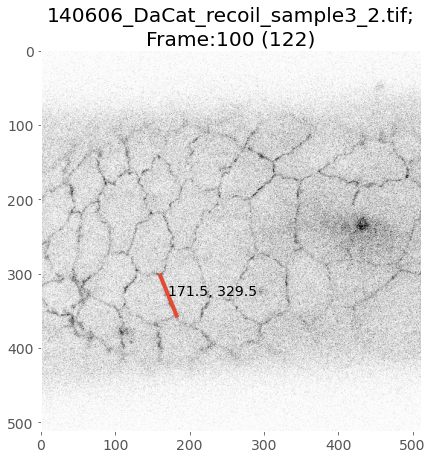

In [497]:
k=needs_mask[0]
mov_name = '_'.join([str(long_mov_names.iloc[k][cname]) for cname in ['Main folder', 'embryo', 'Edge ID']])+'.tif'
print(mov_name)
track_csv = '_'.join([str(long_mov_names.iloc[k][cname]) for cname in ['Main folder', 'embryo', 'Edge ID']])+'_nodes.csv'
print(track_csv)

img = read_tiff_stack(path.join(ablmov_basepath,'movies',mov_name),trim_bound=False)
node_tracking = pd.read_csv(path.join(data_base_path,'nodetracks',track_csv))
edge_pos = [node_tracking.iloc[-1,[2,4]].mean(), node_tracking.iloc[-1,[3,5]].mean()]
print(edge_pos)

plt.imshow(img[-1],cmap='gray_r');plt.grid(False);
plt.plot(node_tracking.iloc[-1,[2,4]], node_tracking.iloc[-1,[3,5]], lw=4);
plt.text(edge_pos[0],edge_pos[1],f'{edge_pos[0]:g}, {edge_pos[1]:g}')
plt.title(f'{mov_name};\nFrame:{node_tracking.iloc[-1].frames:n} ({node_tracking.iloc[-1].t:n})');

- Extract Graphs from Amnioserosa Movies

In [29]:
# root_dir = 'simgnn_data/hara_movies/raw/'
# PROCESS_HARA_MOVIE = False # set to true to process Hara AS tissue movies

# if PROCESS_HARA_MOVIE:
#     for bw_img in seg:
#         edges_index, node2cell_index, v_pos = extract_graph(seg[bw_img], label_bw_stack(seg[bw_img])[0])
#         edge_lengths = np.sqrt(((v_pos[:,edges_index[1],:] - v_pos[:,edges_index[0],:])**2).sum(axis=-1,keepdims=True))

#         dataDir = path.join(root_dir, bw_img)
#         mknewdir(dataDir);

#         write_array(path.join(dataDir, 'edges_index.npy'), edges_index)
#         write_array(path.join(dataDir, 'node2cell_index.npy'), node2cell_index)
#         write_array(path.join(dataDir, 'vtx_pos.npy'), v_pos)
#         write_array(path.join(dataDir, 'edge_Length.npy'), edge_lengths)

# Node Tracking with Napari

**Note** : Restart the jupyter kernel in an env w/ napari !

In [2]:
from skimage import data,io
import napari, numpy as np, glob, pandas as pd
from os import path

from simgnn.datautils import write_array, mknewdir
from simgnn.hara import read_tiff_stack

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')

In [3]:
ablmov_basepath = path.abspath('../../../dataDIR/Hara_ablation_dataset')
data_base_path = './simgnn_data/hara_ablation/'

In [4]:
# last_frame_masks = [path.basename(img_name) for img_name in glob.glob(path.join(ablmov_basepath,'frames_masks','*.tif'))]

In [80]:
sample_name = '140408_SqhGFP_UASDaCatRFP_c381Gal4_sample10_1'
print(sample_name)

img = read_tiff_stack(path.join(ablmov_basepath,'movies',sample_name+'.tif'),trim_bound=False)
last_mask = io.imread(path.join(ablmov_basepath,'frames_masks',sample_name+'_mask.tif'),as_gray=True)

# Hara et al. ablated edge vertices
node_tracking = pd.read_csv(path.join(data_base_path,'nodetracks',sample_name+'_nodes.csv'))
node_tracking['frames'] = node_tracking['frames']-1
edge_pos = [node_tracking.iloc[-1,[2,4]].mean(), node_tracking.iloc[-1,[3,5]].mean()]
print('Edge pos (x,y,t=-1):',edge_pos)
# Reshape dimensions for napari
abltd_verts = node_tracking.iloc[:,[0,3,2,0,5,4]].values.reshape(-1,2,3)
# order of the variables for napari
node_tracking.iloc[:,[0,3,2,0,5,4]].tail(3)

140408_SqhGFP_UASDaCatRFP_c381Gal4_sample10_1
Image stack shape: (56, 512, 512) -- trim boundaries: False
Edge pos (x,y,t=-1): [249.16666666666666, 261.16666666666663]


,frames,y1,x1,frames,y2,x2
53,53,283.166667,211.500000,53,236.5,287.833333
54,54,283.166667,211.500000,54,238.5,287.500000
55,55,283.833333,210.833333,55,238.5,287.500000


In [81]:
viewer = napari.view_image(img,name='movie')
mask_layer = viewer.add_image(last_mask,name='mask',colormap='green',blending='additive',opacity=.5)
abltd_v_layer = viewer.add_shapes(abltd_verts,name='abltn',shape_type='line', edge_width=5,edge_color='red',blending='additive',opacity=.5)